In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack, hstack
import fitsio
# from astropy.io import fits

from sklearn.cluster import DBSCAN

In [2]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [3]:
cat = Table.read('/Users/rongpu/Documents/Data/dr9_tests/outliers/dr9_north_grz_outliers.fits')
print(len(cat))

23625


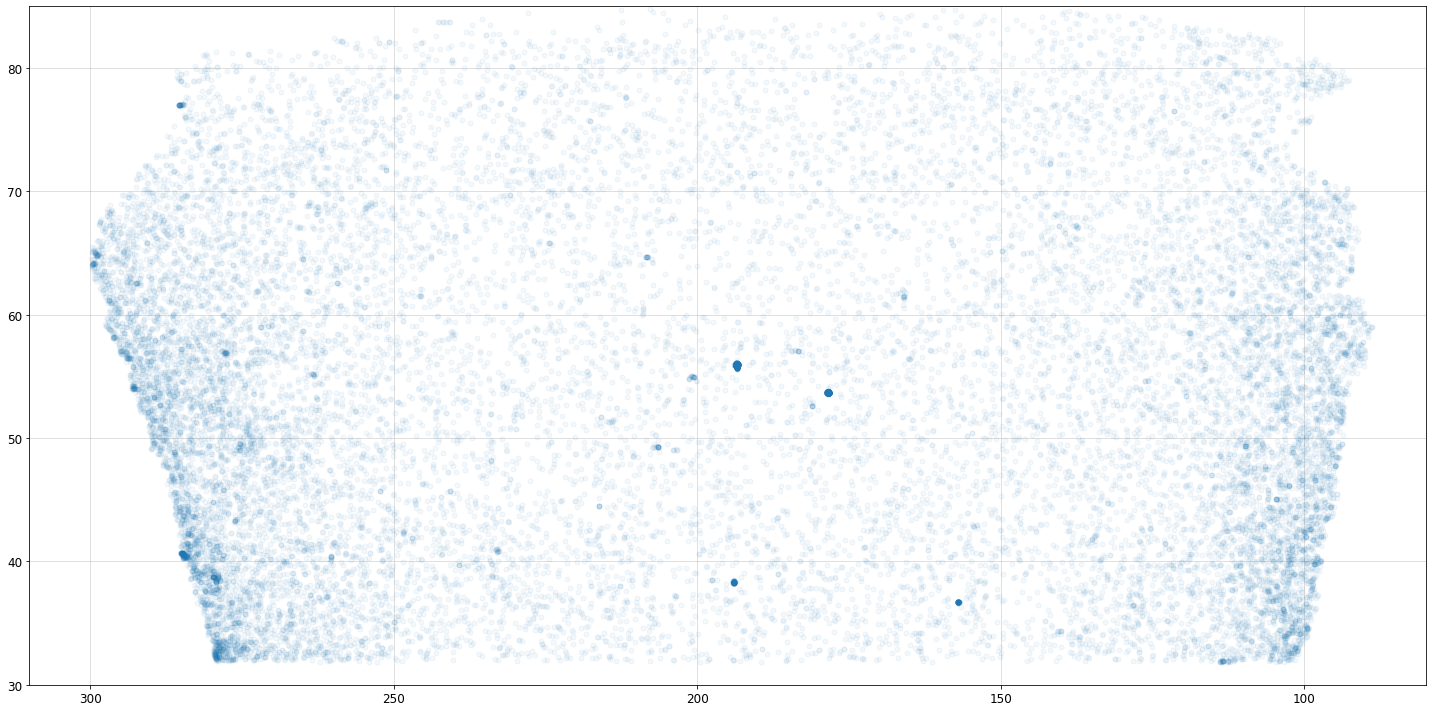

In [4]:
mask = np.ones(len(cat), dtype=bool)
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(cat['RA'][mask], cat['DEC'][mask], '.', ms=10, alpha=0.05)
plt.axis([310, 80, 30, 85])
ax.grid(alpha=0.5)
plt.tight_layout()
plt.savefig('/Users/rongpu/Downloads/corrupt/north.png')
plt.show()

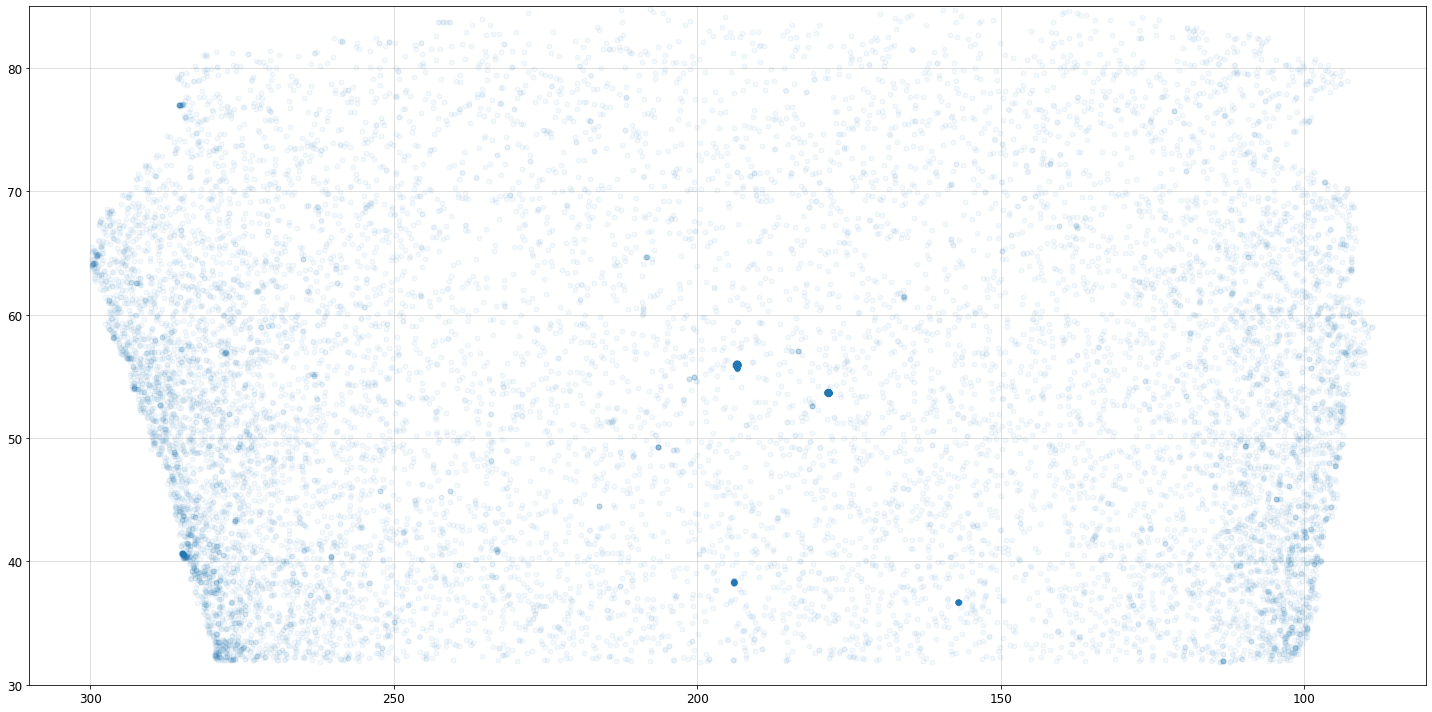

In [5]:
mask = cat['MASKBITS'] & 2**11 ==0
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(cat['RA'][mask], cat['DEC'][mask], '.', ms=10, alpha=0.05)
plt.axis([310, 80, 30, 85])
ax.grid(alpha=0.5)
plt.tight_layout()
plt.savefig('/Users/rongpu/Downloads/corrupt/north_medium.png')
plt.show()

Estimated number of clusters: 237
Fraction of objects in clusters: 15.48%


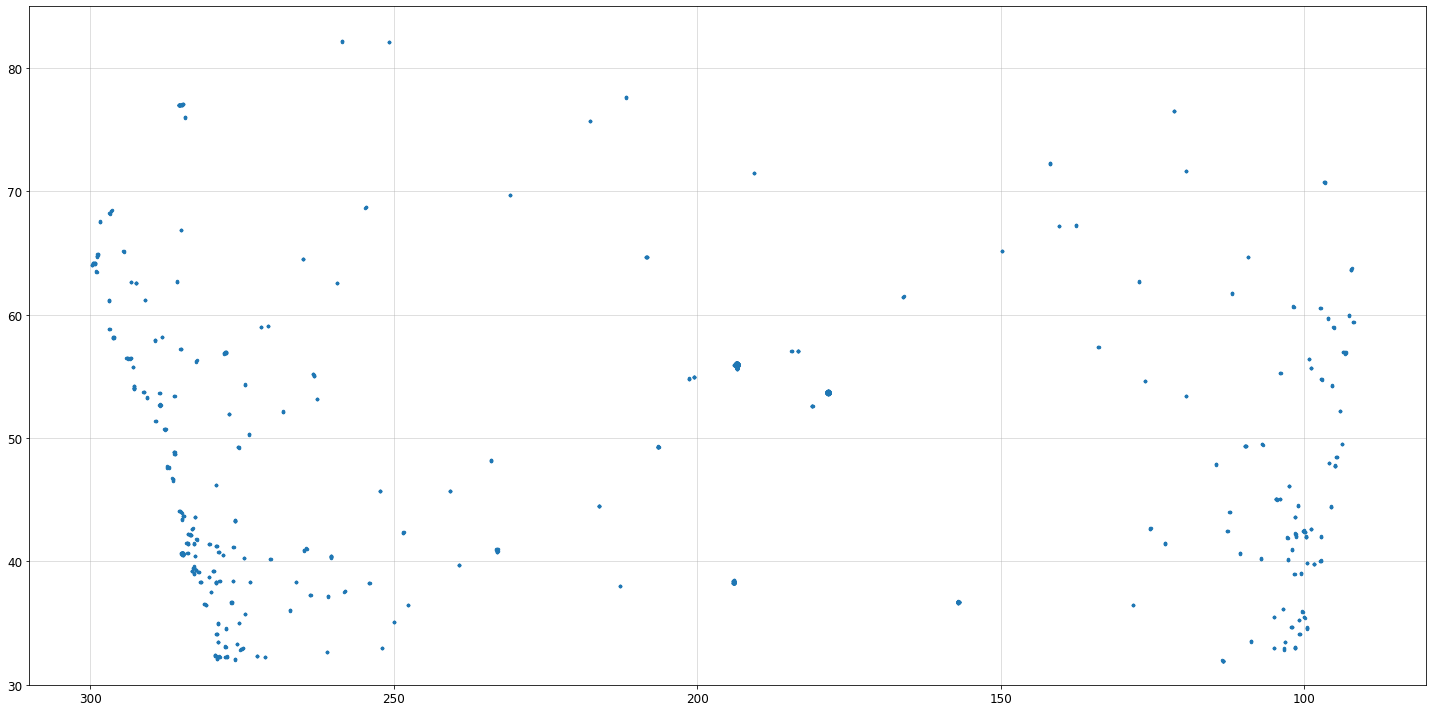

In [14]:
# MEDIUM mask
mask = cat['MASKBITS'] & 2**11 ==0
mask &= cat['NOBS_Z']>=2
ra, dec = cat['RA'][mask], cat['DEC'][mask]
X = np.column_stack([ra, dec])

# Compute DBSCAN
db = DBSCAN(eps=0.1, min_samples=3).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
all_samples_mask = labels>=0

# Number of clusters in labels, ignoring noise if present.
# n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_clusters = len(np.unique(db.labels_[db.labels_!=-1]))

print('Estimated number of clusters: %d' % n_clusters)
print('Fraction of objects in clusters: {:.2f}%'.format(np.sum(core_samples_mask)/len(X)*100))

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(ra[all_samples_mask], dec[all_samples_mask], '.', ms=5, alpha=1)
plt.axis([310, 80, 30, 85])
ax.grid(alpha=0.5)
plt.tight_layout()
plt.savefig('/Users/rongpu/Downloads/corrupt/north_cluster.png')
plt.show()

In [15]:
t = Table()
t['label'], t['counts'] = np.unique(labels, return_counts=True)
mask = t['label']!=-1
t = t[mask]
t['ra'] = 0.
t['dec'] = 0.

for index in range(len(t)):
    label = t['label'][index]
    mask = labels==label
    t['ra'][index] = np.mean(ra[mask])
    t['dec'][index] = np.mean(dec[mask])
    
t.write('/Users/rongpu/Downloads/visual_inspection_north.fits', overwrite=True)
t[['ra', 'dec']].write('/Users/rongpu/Downloads/visual_inspection_north.txt', format='ascii.no_header', overwrite=True)

In [10]:
t = Table()
t['label'], t['counts'] = np.unique(labels, return_counts=True)
t.sort('counts', reverse=True)
t

label,counts
int64,int64
-1,12774
45,651
41,604
0,78
29,60
39,54
22,17
24,12
42,11


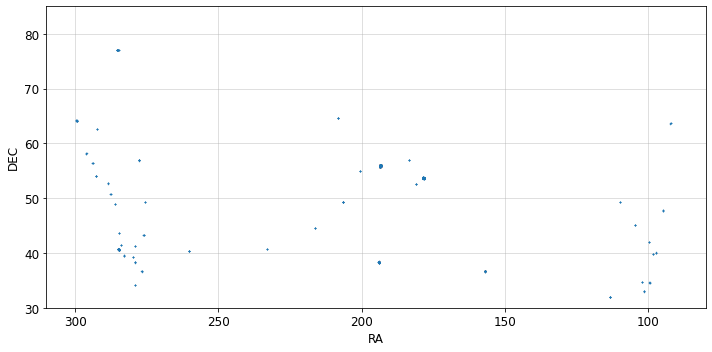

In [12]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(ra[all_samples_mask], dec[all_samples_mask], '.', ms=1, alpha=1)
plt.xlabel('RA')
plt.ylabel('DEC')
plt.axis([310, 80, 30, 85])
ax.grid(alpha=0.5)
plt.tight_layout()
# plt.savefig('/Users/rongpu/Downloads/corrupt/r.png')
plt.show()